#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Основная-информация" data-toc-modified-id="Основная-информация-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Основная информация</a></span></li><li><span><a href="#Разложение-временного-ряда" data-toc-modified-id="Разложение-временного-ряда-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разложение временного ряда</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование-моделей" data-toc-modified-id="Обучение-и-тестирование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и тестирование моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Результаты-вычислений" data-toc-modified-id="Результаты-вычислений-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Результаты вычислений</a></span></li></ul></li><li><span><a href="#Итоги-исследования" data-toc-modified-id="Итоги-исследования-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги исследования</a></span></li></ul></div>

## Введение


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Цель** - построить модель, которая составит прогноз количества заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи**:

1. Загрузить данные и выполнить их ресемплирование по одному часу. 

В рамках подготовки дополнительно сгенерируем фичи:
* календарные: час, день недели, месяц, квартал, рабочий/выходной день, сезон года (весная, лето и тд);
* «отстающие значения»
* скользящее среднее
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

!pip install lightgbm
!pip install catboost
!pip install hyperopt

import lightgbm as lgb
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [2]:
# импорт данных
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0]) # 

print('Проверка расположения даты и времени в хронологическом порядке - ', df.index.is_monotonic, '\n')

# проведем первичную подготовку - ресемплинг данных по 1 часу
df = df.resample('1H').sum()

Проверка расположения даты и времени в хронологическом порядке -  True 



В рамках подготовки дополнительно сгенерируем фичи:
* календарные: час, день недели, месяц, квартал, рабочий/выходной день, сезон года (весная, лето и тд);
* «отстающие значения»
* скользящее среднее


In [3]:
# напишем функцию для генерации фичей

def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    #df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['week'] = df.index.week
    #df['month'] = df.index.month
    #df['quarter'] = df.index.quarter
    df['is_month_start'] = df.index.is_month_start
    df['is_month_end'] = df.index.is_month_end
    
    # отстающие значения ('лаговые' признаки)
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    # скользящее среднее
    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    


"""def make_season(row):
    
    #Фунция, вычисляющая сезон года по месяцу
    
    # присвоим переменной month = row['month']
    month = row['month'] 
    
    # пройдем по данным, проверим условия, присвоим значения
    if month == (12 or 1 or 2):
        return 1
    elif month == (3 or 4 or 5):
        return 2
    elif month == (6 or 7 or 8):
        return 3
    elif month == (9 or 10 or 11):
        return 4
    else:
        return 0 """

def is_weekend_day(row):
    
    """Фунция, вычисляющая выходной/рабочий день по номеру дня недели"""
    
    # присвоим переменной day = row['dayofweek']
    day = row['dayofweek'] 
    
    # пройдем по данным, проверим условия, присвоим значения
    if day == (5 or 6):
        return 1
    else:
        return 0

    
# запустим функции
make_features(df, 2, 24)
#df['season'] = df.apply(make_season, axis=1)
df['is_weekend_day'] = df.apply(is_weekend_day, axis=1)

C:\Users\Danil\AppData\Local\Temp/ipykernel_12320/2632744259.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


In [4]:
# заменим False, True на 0, 1
df.replace(to_replace=[False, True], value=[0, 1], inplace=True)

# удалим пустые значения
df.dropna(inplace=True)

# проверим
df.sample(10)

,num_orders,hour,dayofweek,week,is_month_start,is_month_end,lag_1,lag_2,rolling_mean,is_weekend_day
datetime,,,,,,,,,,
2018-04-29 15:00:00,85,15,6,17,0,0,62.0,62.0,77.500000,0
2018-05-27 03:00:00,68,3,6,21,0,0,106.0,73.0,77.625000,0
2018-08-28 01:00:00,133,1,1,35,0,0,192.0,157.0,161.041667,0
2018-04-11 22:00:00,113,22,2,15,0,0,43.0,60.0,57.000000,0
2018-05-16 21:00:00,64,21,2,20,0,0,63.0,86.0,68.833333,0
2018-06-29 17:00:00,115,17,4,26,0,0,134.0,64.0,87.625000,0
2018-03-27 10:00:00,84,10,1,13,0,0,32.0,69.0,55.458333,0
2018-04-29 01:00:00,83,1,6,17,0,0,129.0,107.0,77.416667,0
2018-08-10 10:00:00,153,10,4,32,0,0,81.0,67.0,106.541667,0


In [5]:
# проверим первые 5 верхних строк
df.head()

,num_orders,hour,dayofweek,week,is_month_start,is_month_end,lag_1,lag_2,rolling_mean,is_weekend_day
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,9,0,0,58.0,113.0,56.833333,0
2018-03-02 01:00:00,120,1,4,9,0,0,90.0,58.0,55.416667,0
2018-03-02 02:00:00,75,2,4,9,0,0,120.0,90.0,56.875000,0
2018-03-02 03:00:00,64,3,4,9,0,0,75.0,120.0,57.041667,0
2018-03-02 04:00:00,20,4,4,9,0,0,64.0,75.0,56.958333,0


## Анализ

### Основная информация

In [6]:
# выведем основную информацию о датафрейме
df.info()
display(df.describe())

print('\n Первые и последние 5 строк датафрейма:')
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4392 non-null   int64  
 1   hour            4392 non-null   int64  
 2   dayofweek       4392 non-null   int64  
 3   week            4392 non-null   int64  
 4   is_month_start  4392 non-null   int64  
 5   is_month_end    4392 non-null   int64  
 6   lag_1           4392 non-null   float64
 7   lag_2           4392 non-null   float64
 8   rolling_mean    4392 non-null   float64
 9   is_weekend_day  4392 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 377.4 KB


,num_orders,hour,dayofweek,week,is_month_start,is_month_end,lag_1,lag_2,rolling_mean,is_weekend_day
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,84.573543,11.500000,3.005464,22.142077,0.027322,0.032787,84.540073,84.515027,84.257153,0.142077
std,45.050123,6.922975,1.996117,7.556955,0.163040,0.178099,45.015225,44.968748,26.308289,0.349168
min,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,42.375000,0.000000
25%,54.000000,5.750000,1.000000,16.000000,0.000000,0.000000,54.000000,54.000000,63.666667,0.000000
50%,78.000000,11.500000,3.000000,22.000000,0.000000,0.000000,78.000000,78.000000,79.708333,0.000000
75%,108.000000,17.250000,5.000000,29.000000,0.000000,0.000000,108.000000,108.000000,99.802083,0.000000
max,462.000000,23.000000,6.000000,35.000000,1.000000,1.000000,462.000000,462.000000,176.916667,1.000000



 Первые и последние 5 строк датафрейма:


,num_orders,hour,dayofweek,week,is_month_start,is_month_end,lag_1,lag_2,rolling_mean,is_weekend_day
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,9,0,0,58.0,113.0,56.833333,0
2018-03-02 01:00:00,120,1,4,9,0,0,90.0,58.0,55.416667,0
2018-03-02 02:00:00,75,2,4,9,0,0,120.0,90.0,56.875000,0
2018-03-02 03:00:00,64,3,4,9,0,0,75.0,120.0,57.041667,0
2018-03-02 04:00:00,20,4,4,9,0,0,64.0,75.0,56.958333,0


,num_orders,hour,dayofweek,week,is_month_start,is_month_end,lag_1,lag_2,rolling_mean,is_weekend_day
datetime,,,,,,,,,,
2018-08-31 19:00:00,136,19,4,35,0,1,207.0,217.0,164.875000,0
2018-08-31 20:00:00,154,20,4,35,0,1,136.0,207.0,167.541667,0
2018-08-31 21:00:00,159,21,4,35,0,1,154.0,136.0,168.041667,0
2018-08-31 22:00:00,223,22,4,35,0,1,159.0,154.0,166.416667,0
2018-08-31 23:00:00,205,23,4,35,0,1,223.0,159.0,169.125000,0


Выведем график заказов по часам и дням на экран

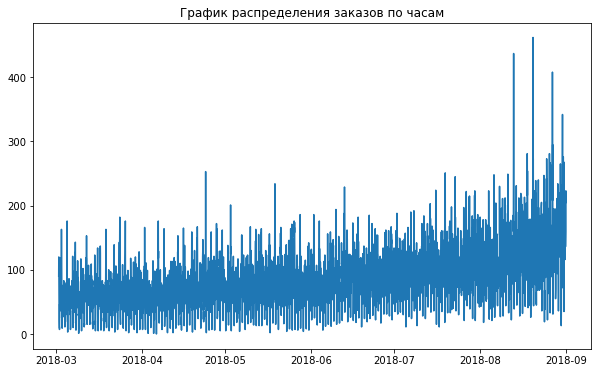

In [7]:
plt.figure(figsize=(10,6))
plt.plot(df['num_orders'])
plt.title('График распределения заказов по часам')
plt.show()

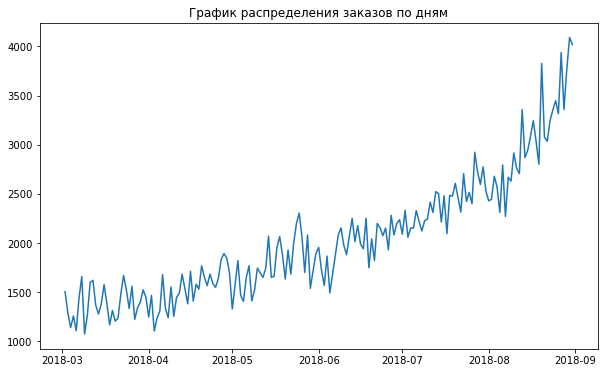

In [8]:
plt.figure(figsize=(10,6))
plt.plot(df['num_orders'].resample('1D').sum())
plt.title('График распределения заказов по дням')
plt.show()

**Вывод**
* указанный временной ряд нестационарен, т.к. со временем меняется среднее значение заказов как по часам, так и по дням;
* на графике по дням отчетливо виден восходящий тренд количества заказов к концу временного ряда

**Общий вывод:**
* данные представлены временными рядами с 2018-03-01 по 2018-08-31, расположеными в хронологическом порядке
* пропуски отсутствуют
* имеется большой разброс в значениях: ср.знач - 14, ст.отклон - 8, мин и макс значения - 0 и 77 соответственно
* гистограмма распределения по количеству заказов имеет форму нормального распределения со скошенностью вправо
* наблюдаются локальные выбросы в распределении общего количества заказов по часам;
* наибольший всплеск заказов наблюдается с 23:00 до 04:00 часов, в районе 09:00-10:00 и 16:00-17:00 часов
* среди популярных дней заказа выделяются понедельник и пятница с точки зрения медианного значения и разброса в кол-ве заказов;
* динамика по месяцам показывает, что чем ближе лето, тем выше количество заказов, особенно выделяется август

### Разложение временного ряда

Разложим временной ряд на сезоннную составляющую, тред и остаток

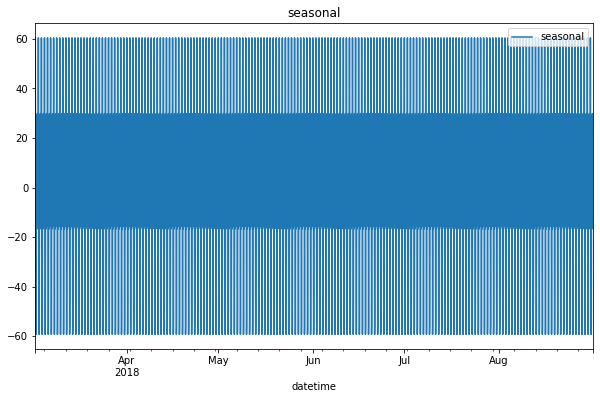

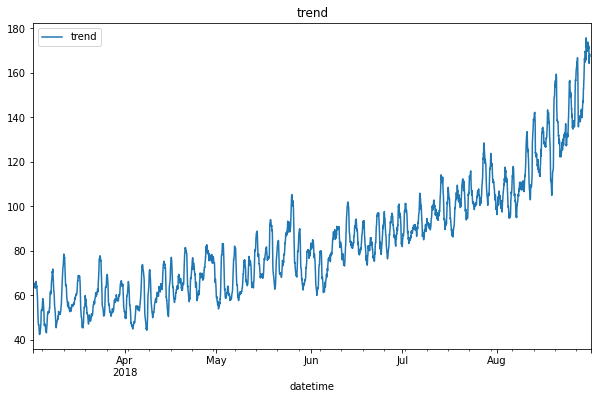

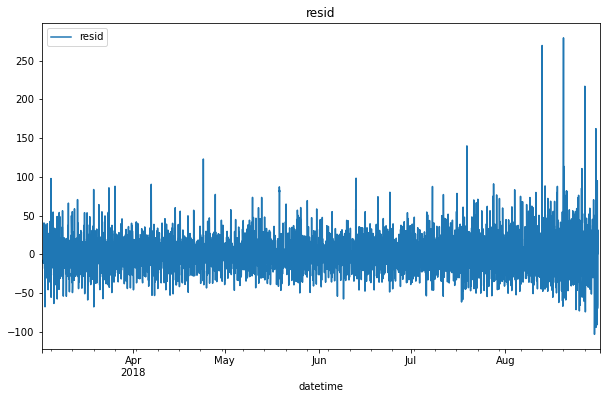

In [9]:
decompose = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(10,6))
decompose.seasonal.plot(kind='line', title='seasonal')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
decompose.trend.plot(kind='line', title='trend')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
decompose.resid.plot(kind='line', title='resid')
plt.legend()
plt.show()


**Вывод**
* временной ряд имеет восходящий тренд
* временной ряд имеет большую долю "остатка", колебания значений которого сильно растет к концу периода

## Обучение и тестирование моделей

1) разделим фичи и целевой признак


2) сделаем тестовую выборку размером 10% от исходных данных;


3) Обучим различные модели со стандартными гиперпараметрами:
* Линейная регрессия
* Случайный лес
* CatBoost
* LightGBM

In [10]:
# 1)  разделим фичи и целевой признак
y = df['num_orders']
X = df.drop('num_orders', axis=1)

# 2) сделаем тестовую выборку размером 10% от исходных данных;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, shuffle=False)

In [11]:
# проверим разбивку
print('Границы train-выборки: ', X_train.index.min(),'|', X_train.index.max())
print('Границы test-выборки:  ', X_test.index.min(), '|', X_test.index.max())

Границы train-выборки:  2018-03-02 00:00:00 | 2018-08-13 15:00:00
Границы test-выборки:   2018-08-13 16:00:00 | 2018-08-31 23:00:00


In [12]:
# создадим пустой словарь для записи результатов работы моделей
results_dict = {'LinearRegression':list(),
                'RandomForestRegressor':list(),
                'CatBoostRegressor':list(),
                'LGBMRegressor':list(),
                'LGBMRegressor with hyperopt':list()}

### Линейная регрессия

In [13]:
model = LinearRegression()

model.fit(X_train, y_train)
pred_lin = model.predict(X_test)

mse = mean_squared_error(pred_lin, y_test)
rmse = mse ** .5

# запишем результат метрики в словарь
results_dict['LinearRegression'] = rmse

print('RMSE LinearRegression - ', rmse)

RMSE LinearRegression -  51.97341688370499


Выведем на экран график тестовых значений и предсказаний модели:

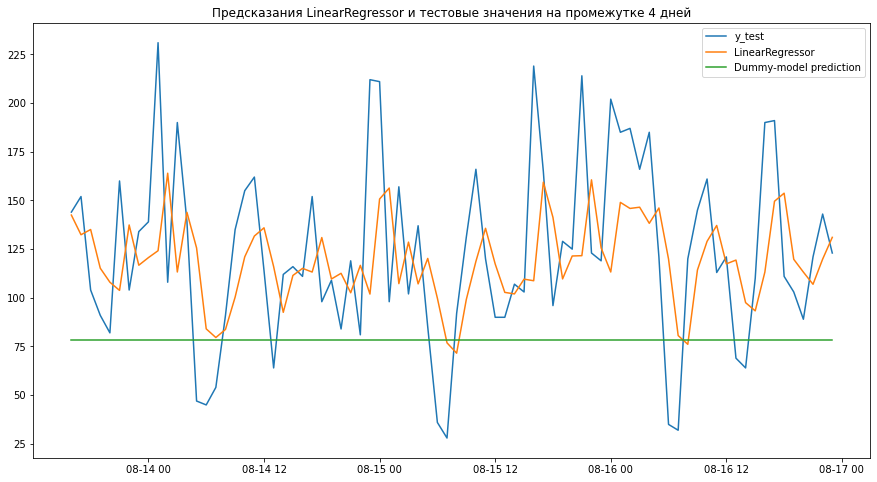

In [14]:
# запишем результат предсказаний в Series
pred_lin = pd.Series(pred_lin, index=y_test.index)

# построим график за период с '2018-08-13' до '2018-08-16'
plt.figure(figsize=(15,8))

plt.plot(y_test[:'2018-08-16'].index, y_test[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pred_lin[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pd.Series(y_train.mean(), index=y_test[:'2018-08-16'].index))
plt.legend(['y_test', 'LinearRegressor', 'Dummy-model prediction'])
plt.title('Предсказания LinearRegressor и тестовые значения на промежутке 4 дней')
plt.show()

### Случайный лес

In [15]:
model = RandomForestRegressor(random_state=1)

model.fit(X_train, y_train)
pred_forest = model.predict(X_test)

mse = mean_squared_error(pred_forest, y_test)
rmse = mse ** .5

# запишем результат метрики в словарь
results_dict['RandomForestRegressor'] = rmse

print('RMSE RandomForestRegressor - ', rmse)

RMSE RandomForestRegressor -  46.66163283537811


Выведем на экран график тестовых значений и предсказаний модели:

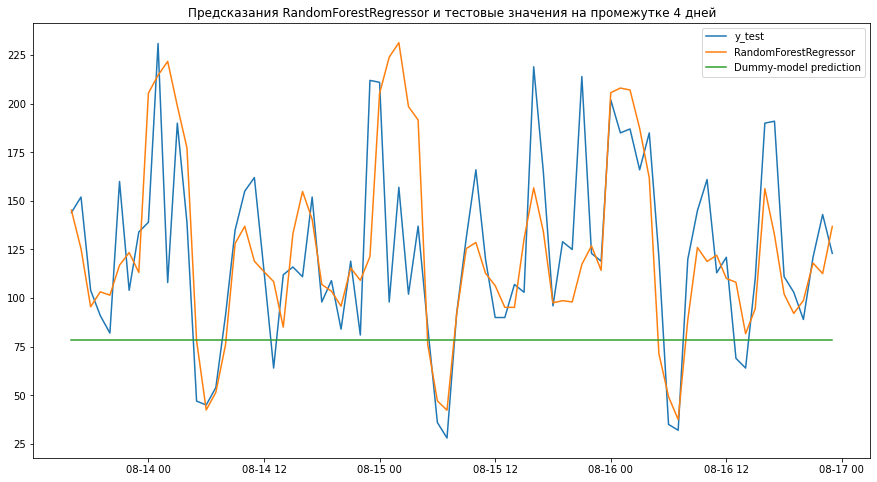

In [16]:
# запишем результат предсказаний в Series
pred_forest = pd.Series(pred_forest, index=y_test.index)

# построим график за период с '2018-08-13' до '2018-08-16'
plt.figure(figsize=(15,8))

plt.plot(y_test[:'2018-08-16'].index, y_test[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pred_forest[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pd.Series(y_train.mean(), index=y_test[:'2018-08-16'].index))
plt.legend(['y_test', 'RandomForestRegressor', 'Dummy-model prediction'])
plt.title('Предсказания RandomForestRegressor и тестовые значения на промежутке 4 дней')
plt.show()

### CatBoostRegressor

In [17]:
ctb = CatBoostRegressor()

ctb.fit(X_train, y_train)
pred_ctb = ctb.predict(X_test)

mse = mean_squared_error(pred_ctb, y_test)
rmse = mse ** .5

# запишем результат метрики в словарь
results_dict['CatBoostRegressor'] = rmse

print('RMSE CatBoostRegressor - ', rmse)

Learning rate set to 0.050872
0:	learn: 37.7835304	total: 143ms	remaining: 2m 22s
1:	learn: 36.8268314	total: 145ms	remaining: 1m 12s
2:	learn: 36.0037135	total: 146ms	remaining: 48.6s
3:	learn: 35.2420753	total: 148ms	remaining: 36.9s
4:	learn: 34.6073140	total: 150ms	remaining: 29.8s
5:	learn: 34.0638317	total: 152ms	remaining: 25.1s
6:	learn: 33.3737417	total: 153ms	remaining: 21.7s
7:	learn: 32.8613561	total: 155ms	remaining: 19.2s
8:	learn: 32.3604248	total: 157ms	remaining: 17.3s
9:	learn: 31.9419359	total: 158ms	remaining: 15.7s
10:	learn: 31.5406411	total: 160ms	remaining: 14.4s
11:	learn: 31.1045667	total: 162ms	remaining: 13.3s
12:	learn: 30.6466061	total: 164ms	remaining: 12.4s
13:	learn: 30.1765866	total: 166ms	remaining: 11.7s
14:	learn: 29.8466936	total: 167ms	remaining: 11s
15:	learn: 29.5037781	total: 169ms	remaining: 10.4s
16:	learn: 29.1452177	total: 171ms	remaining: 9.87s
17:	learn: 28.8646025	total: 172ms	remaining: 9.4s
18:	learn: 28.5331648	total: 174ms	remaining:

Выведем на экран график тестовых значений и предсказаний модели:

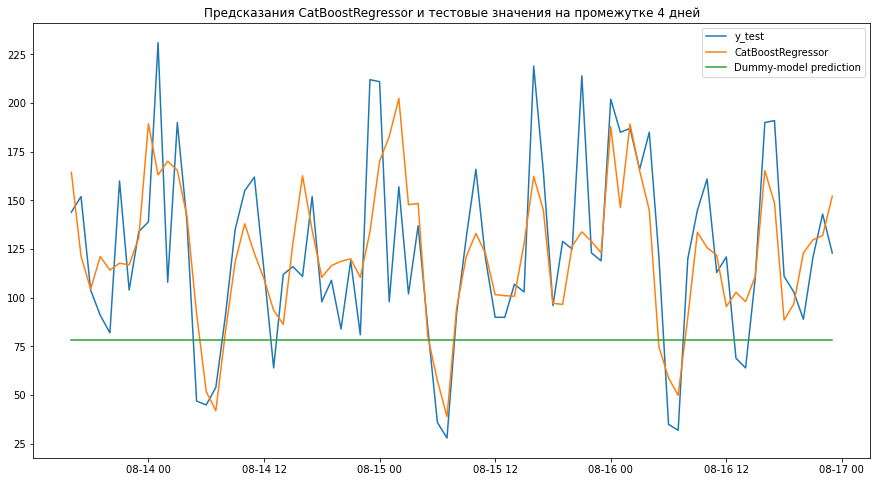

In [18]:
# запишем результат предсказаний в Series
pred_ctb = pd.Series(pred_ctb, index=y_test.index)

# построим график за период с '2018-08-13' до '2018-08-16'
plt.figure(figsize=(15,8))

plt.plot(y_test[:'2018-08-16'].index, y_test[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pred_ctb[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pd.Series(y_train.mean(), index=y_test[:'2018-08-16'].index))
plt.legend(['y_test', 'CatBoostRegressor', 'Dummy-model prediction'])
plt.title('Предсказания CatBoostRegressor и тестовые значения на промежутке 4 дней')
plt.show()

### LGBMRegressor

In [19]:
# присвоим объекту lgbmr структуру данных LGBMRegressor()
lgbmr = lgb.LGBMRegressor(random_state=1)

# обучим модель на train features
lgbmr.fit(X_train, y_train)

# выполним предсказания на тестовой выборке
pred_lgb = lgbmr.predict(X_test)

# выполним расчет целевой метрики rmse
mse = mean_squared_error(pred_lgb, y_test)
rmse = mse ** .5

# запишем результат в словарь results_dict
results_dict['LGBMRegressor'] = rmse

print('RMSE LGBMRegressor - ', rmse)

RMSE LGBMRegressor -  44.175615058431276


Выведем на экран график тестовых значений и предсказаний модели:

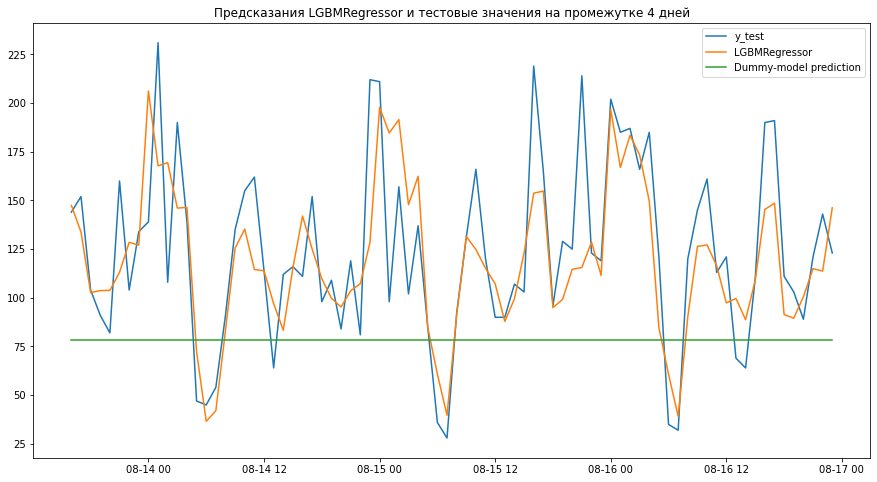

In [20]:
# запишем результат предсказаний в Series
pred_lgb = pd.Series(pred_lgb, index=y_test.index)

# построим график за период с '2018-08-13' до '2018-08-16'
plt.figure(figsize=(15,8))

plt.plot(y_test[:'2018-08-16'].index, y_test[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pred_lgb[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pd.Series(y_train.mean(), index=y_test[:'2018-08-16'].index))
plt.legend(['y_test', 'LGBMRegressor', 'Dummy-model prediction'])
plt.title('Предсказания LGBMRegressor и тестовые значения на промежутке 4 дней')
plt.show()

Выполним подбор оптимальных гиперпараметров LGBMRegressor с помощью `hyperopt`:

In [44]:
# обозначим параметры модели LightGBM

trials = Trials()

lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     10,
}

lgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [45]:
# создадим класс HPOpt, в котором настроим обучение, тестирование модели и расчет итоговой метрики качества
class HPOpt(object):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.x_train = X_train
        self.x_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        return result, trials #, pred


    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'], random_state=1)
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK, 'predictions':pred} #

In [46]:
# присвоим obj структуру данных HPOpt, в которую передадим наши тестовые и обучающие выборки
obj = HPOpt(X_train, X_test, y_train, y_test)

# запустим процесс обучения модели
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=trials, algo=tpe.suggest, max_evals=100)

  3%|█▍                                               | 3/100 [00:00<00:04, 22.21trial/s, best loss: 45.55728522475681]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

  9%|████▍                                            | 9/100 [00:00<00:04, 20.64trial/s, best loss: 45.55728522475681]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 12%|█████▊                                          | 12/100 [00:00<00:04, 21.58trial/s, best loss: 45.55728522475681]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 18%|████████▋                                       | 18/100 [00:00<00:03, 20.86trial/s, best loss: 45.55728522475681]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 21%|██████████                                      | 21/100 [00:01<00:04, 19.42trial/s, best loss: 45.55728522475681]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 23%|███████████                                     | 23/100 [00:01<00:04, 18.62trial/s, best loss: 45.55728522475681]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 27%|████████████▉                                   | 27/100 [00:01<00:04, 17.50trial/s, best loss: 45.50480490634816]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 33%|███████████████▊                                | 33/100 [00:01<00:03, 17.51trial/s, best loss: 45.50480490634816]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 35%|████████████████▊                               | 35/100 [00:01<00:03, 17.04trial/s, best loss: 45.50480490634816]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 39%|██████████████████▋                             | 39/100 [00:02<00:03, 16.50trial/s, best loss: 45.50480490634816]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 43%|████████████████████▋                           | 43/100 [00:02<00:03, 15.52trial/s, best loss: 45.50480490634816]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 47%|██████████████████████▌                         | 47/100 [00:02<00:03, 16.58trial/s, best loss: 45.50480490634816]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 53%|█████████████████████████▍                      | 53/100 [00:02<00:02, 16.99trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 57%|███████████████████████████▎                    | 57/100 [00:03<00:02, 17.70trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 61%|█████████████████████████████▎                  | 61/100 [00:03<00:02, 18.26trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 65%|███████████████████████████████▏                | 65/100 [00:03<00:01, 17.87trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 67%|████████████████████████████████▏               | 67/100 [00:03<00:01, 17.97trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 73%|███████████████████████████████████             | 73/100 [00:04<00:01, 18.05trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 75%|████████████████████████████████████            | 75/100 [00:04<00:01, 18.15trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 81%|██████████████████████████████████████▉         | 81/100 [00:04<00:01, 18.13trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 85%|████████████████████████████████████████▊       | 85/100 [00:04<00:00, 17.87trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 89%|██████████████████████████████████████████▋     | 89/100 [00:04<00:00, 17.60trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 93%|████████████████████████████████████████████▋   | 93/100 [00:05<00:00, 17.78trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

 97%|██████████████████████████████████████████████▌ | 97/100 [00:05<00:00, 17.45trial/s, best loss: 45.47280716876757]

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 17.88trial/s, best loss: 45.47280716876757]


C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Danil\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argume

In [47]:
# запишем результат работы в итоговый словарь
loss_df = pd.DataFrame(trials.results)
rmse = loss_df['loss'].min()

results_dict['LGBMRegressor with hyperopt'] = rmse

print('RMSE LGBMRegressor with hyperopt - ', rmse)

RMSE LGBMRegressor with hyperopt -  45.47280716876757


In [48]:
# найдем индекс строки, в которой rmse минимален
rmse_min_index = loss_df[ loss_df['loss'] == rmse ].index[0]

# запишем в Series результаты предсказаний
pred_lgbHopt = pd.Series(loss_df['predictions'].loc[rmse_min_index], index=y_test.index)
pred_lgbHopt

datetime
2018-08-13 16:00:00    141.770026
2018-08-13 17:00:00    134.160315
2018-08-13 18:00:00     86.490369
2018-08-13 19:00:00     98.392651
2018-08-13 20:00:00     98.697529
                          ...    
2018-08-31 19:00:00    140.331624
2018-08-31 20:00:00    128.905491
2018-08-31 21:00:00    131.352033
2018-08-31 22:00:00    145.783765
2018-08-31 23:00:00    158.345424
Freq: H, Length: 440, dtype: float64

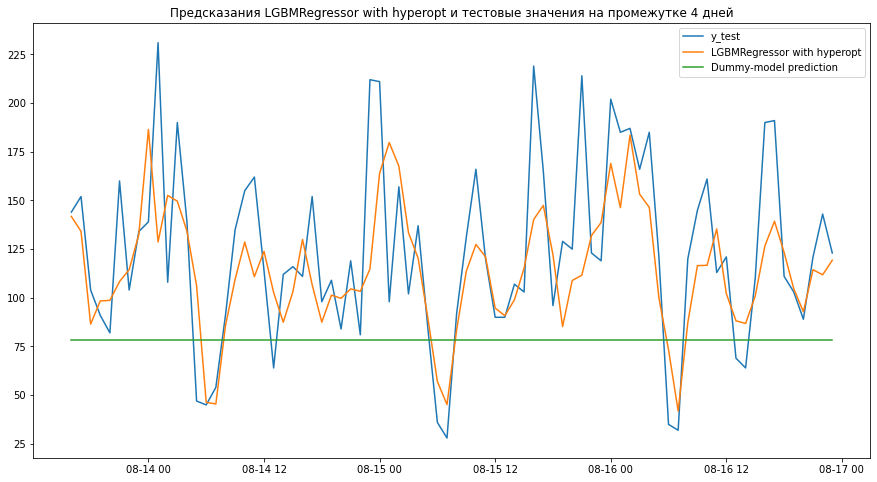

In [49]:
# построим график за период с '2018-08-13' до '2018-08-16'
plt.figure(figsize=(15,8))

plt.plot(y_test[:'2018-08-16'].index, y_test[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pred_lgbHopt[:'2018-08-16'])
plt.plot(y_test[:'2018-08-16'].index, pd.Series(y_train.mean(), index=y_test[:'2018-08-16'].index))
plt.legend(['y_test', 'LGBMRegressor with hyperopt', 'Dummy-model prediction'])
plt.title('Предсказания LGBMRegressor with hyperopt и тестовые значения на промежутке 4 дней')
plt.show()

### Результаты вычислений

Выведем таблицу с результатами RMSE моделей на тестовой выборке:

In [50]:
pd.Series(results_dict)

LinearRegression               51.973417
RandomForestRegressor          46.661633
CatBoostRegressor              43.200983
LGBMRegressor                  44.175615
LGBMRegressor with hyperopt    45.472807
dtype: float64

## Итоги исследования

**Прогнозирование заказов такси** - исследовательский проект, целью которого былоо построить модель, которая бы составила прогноз количества заказов такси на следующий час.

Для достижения цели были поставлены и решены следующие задачи:
1) Загружены данные и выполнено их ресемплирование по одному часу.

Дополнительно сгенерированы фичи:
* календарные: час, день недели, месяц, квартал, рабочий/выходной день, сезон года (весная, лето и тд);
* «отстающие значения»
* скользящее среднее

2) Проанализированы входные данные;

3) Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

4) Проверить данные на тестовой выборке и сделать выводы.


По результатам обучения и тестирования моделей было получена следующая целевая метрика RMSE на тестовой выборке:
* LinearRegression            | `51.973417`
* RandomForestRegressor       | `46.661633`
* CatBoostRegressor           | `43.200983`
* LGBMRegressor               | `44.175615`
* LGBMRegressor with hyperopt | `45.472807`

Таким образом, по всем рассматриваемым моделям был получен приблизительно одинаковый результат. Наилучшей, с точки зрения предсказаний, оказалась модель `CatBoostRegressor с RMSE на тестовой выборке - 43.200983`.